In [4]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch
import glob, os
from photometryExercise import standardPlot
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photometryExercise import standardPlot
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, ApertureStats
from matplotlib.colors import LogNorm

In [5]:
from bokeh.io import show, output_notebook
# set local host for bokeh (change the number to the one in the url at the top of the page)
localhost = 'localhost:8888'

In [6]:
output_notebook()

Loading BokehJS ...

In [7]:
pip install astropy

Note: you may need to restart the kernel to use updated packages.


In [8]:
def show_fits(data, title=""):
    """
    stolen from the obs astro code but like the backend code they wrote which we didn't see
    """
    plt.figure(figsize=(8, 8))
    
    # Use ZScale for astronomical images
    interval = ZScaleInterval()
    vmin, vmax = interval.get_limits(data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())
    
    plt.imshow(data, origin='lower', cmap='gray', norm=norm)
    plt.colorbar(label='Counts')
    plt.title(title)
    print(f"{title}: min={np.min(data):.1f}, max={np.max(data):.1f}, median={np.median(data):.1f}")
    print(f"Display range (ZScale): {vmin:.1f} to {vmax:.1f}")
    plt.show()
    
trim = 50  # idk what this should be lol

In [9]:
# a function that takes the total flux as input and returns a magnitude value

def flux_to_mag(C):

    # check if the counts are negative
    if C <= 0:
        print("Counts are non-positive")
        return np.nan
        
    return - 2.5 * np.log10(C)

In [10]:
# a function as well that estimates the error on the magnitude measuments

# C is the counts from the object
# s is the counts from the sky

def error_in_mag(C, s):

    # calculate the total counts within the aperture t
    t = C + s

    # calculate the final area of the objects counts by summing in quadrature of the errors
    del_C = np.sqrt(t + s)

    # calculate and return the magnitude error
    return - 2.5 / np.log(10) * (del_C / C)

In [11]:
# write a function to obtain all the instrumental magnitudes and the errors 
def instrumental_magnitudes(f, xcor, ycor, rAperture=5):
    # where f is the individual file for each standard

    standard = fits.open(f)[0].data

    # create the ciruclar aperture and sky annulus
    rSkyInner = 1.5 * rAperture
    rSkyOuter = 2 * rAperture

    apertureStandard = CircularAperture((xcor, ycor), r=rAperture)
    annulusSky = CircularAnnulus((xcor, ycor), r_in=rSkyInner, r_out=rSkyOuter)

    # make an estimation of the sky values in the defined annulus
    # aperture_photometry returns an astropy.table with the center of the aperture and 
    # the total flux on the aperture ('aperture_sum')
    sky = aperture_photometry(standard, annulusSky)
    #print(sky)

    # to recover the mean sky value, weight the total flux by the area of the annulus
    area = np.pi * (rSkyOuter ** 2 - rSkyInner **2)
    skyFlux = sky['aperture_sum'].value[0]
    meanSkyValue = skyFlux / area
    #print(f'The sky flux is {skyFlux}')
    #print(f'The mean sky value is {meanSkyValue}')

    # remove the sky value
    standard = aperture_photometry(standard - meanSkyValue, apertureStandard)

    # extract value from astropy.table
    standardFlux = standard['aperture_sum'].value[0]
    #print(f'The total flux on aperture is {standardFlux}')

    # calculating instrumental magnitude and its errors and append to list
    instrumental_magnitude = flux_to_mag(standardFlux)
    instrumental_magnitude_error = error_in_mag(standardFlux, skyFlux)

    return instrumental_magnitude, instrumental_magnitude_error

In [12]:
# write a function to obtain the airmass
def airmasses(f):
    # where f is the individual file for each standard

    with fits.open(f) as hdul:
        header = hdul[0].header

    altitude = header['ALTITUDE']
    #print(f"the altitude is {altitude}")
    zenith_angle = 90.0 - altitude
    #print(f"the zenith angle is {zenith_angle}")

    # convert to radians
    zenith_angle_rad = np.deg2rad(zenith_angle)

    # calcualte airmass
    airmass = 1.0 / np.cos(zenith_angle_rad)
    #print(f"the airmass is {airmass}")

    return airmass

In [13]:
# write a function to obtain the coordinates to follow a star from initial coordinates
def coordinates(f, xcor, ycor, aperture_radius = 5, sigma = 3.0, fwhm = 3.0):

    # open data
    hdul = fits.open(f)
    image_data = hdul[0].data

    # Detect stars in this image
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma*std)
    sources = daofind(image_data - median)

    # Find the detected star closest to your expected position
    distances = np.sqrt((sources['xcentroid'] - xcor)**2 + (sources['ycentroid'] - ycor)**2)
    idx = np.argmin(distances)
    star_pos = (sources['xcentroid'][idx], sources['ycentroid'][idx])

    # Photometry at the detected position
    #aperture = CircularAperture(star_pos, r=aperture_radius)
    #aperstats = ApertureStats(image_data, aperture)
    hdul.close()

    return star_pos

In [14]:
# a function to show the plot and location of the star

def star_location_plot(f, xcor, ycor, xmin=700, xmax=1200, ymin=700, ymax=1200):

    fwhm = 3.0
    sigma = 3.0

    # open data
    hdul = fits.open(f)
    image_data = hdul[0].data

    # Detect stars in this image
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma*std)
    sources = daofind(image_data - median)

    # Find the detected star closest to your expected position
    distances = np.sqrt((sources['xcentroid'] - xcor)**2 + (sources['ycentroid'] - ycor)**2)
    idx = np.argmin(distances)
    star_pos = (sources['xcentroid'][idx], sources['ycentroid'][idx])

    x2 = 98
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=6)
    plt.figure()
    plt.imshow(image_data, origin='lower', norm=LogNorm(vmin=np.median(image_data), vmax=np.percentile(image_data, x2)), interpolation='nearest')
    apertures.plot(color='blue', lw=1.0, alpha=0.5)

    target_aperture = CircularAperture(star_pos, r=6)
    target_aperture.plot(color='red', lw=1.0, alpha=0.5) # Use a slightly thicker line (lw=2.5) for visibility
    
    plt.xlim(700, 1200)  # x-axis pixel range
    plt.ylim(700, 1200)  # y-axis pixel range
    
    print(f, star_pos[0], star_pos[1])
    
    plt.show()

In [15]:
# path settings
BASE_DIR = "data"

# standard stars + target fits files
STANDARD_DIR = os.path.join(BASE_DIR, "standards")

# individual standard stars + target
STAR1 = os.path.join(STANDARD_DIR, "star1")
STAR2 = os.path.join(STANDARD_DIR, "star2")
STAR3 = os.path.join(STANDARD_DIR, "star3")
STAR4 = os.path.join(STANDARD_DIR, "star4")
TARGET = os.path.join(STANDARD_DIR, "target")

# retrieving the data from the folders
star1_files = sorted(glob.glob(os.path.join(STAR1, "*.fits")))
star2_files = sorted(glob.glob(os.path.join(STAR2, "*.fits")))
star3_files = sorted(glob.glob(os.path.join(STAR3, "*.fits")))
star4_files = sorted(glob.glob(os.path.join(STAR4, "*.fits")))
target_files = sorted(glob.glob(os.path.join(TARGET, "*.fits")))

In [16]:
# find coordinates for star 1
with fits.open(star1_files[3]) as hdul:
    #print(star1_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

In [17]:
# print out the locations of star1 images

# for the B filter
#for f in star1_files[:3]:
#    star_location_plot(f, 970.50, 982.54)

# for the other filters
#for f in star1_files[3:]:
#    star_location_plot(f, 986, 912)

In [18]:
# write a loop to obtain the instrumental magnitude and its errors
# for star1

star1_ins_mag = []
star1_ins_mag_err = []
star1_airmass = []
star1_tidied_f1 = []

for f in star1_files[:3]:

    # found only using the first image: PIRATE_OSL_ROE_EXO1_star1_filter_B_2.fits
    xcor = 970.50
    ycor = 982.54

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star1/"
    tidied_f1 = f.replace(prefix_to_remove, "")
    star1_tidied_f1.append(tidied_f1)
    print(tidied_f1, ins_mag, ins_mag_err, airmass)

    star1_ins_mag.append(ins_mag)
    star1_ins_mag_err.append(ins_mag_err)
    star1_airmass.append(airmass)

for f in star1_files[3:]:

    # found only using the first image: PIRATE_OSL_ROE_EXO1_star1_filter_B_2.fits
    xcor = 986.50
    ycor = 912.54

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star1/"
    tidied_f1 = f.replace(prefix_to_remove, "")
    star1_tidied_f1.append(tidied_f1)
    print(tidied_f1, ins_mag, ins_mag_err, airmass)

    star1_ins_mag.append(ins_mag)
    star1_ins_mag_err.append(ins_mag_err)
    star1_airmass.append(airmass)

PIRATE_OSL_ROE_EXO1_star1_filter_B_1.fits -8.063245723038097 -0.04276909242720514 1.1335445705650047
PIRATE_OSL_ROE_EXO1_star1_filter_B_2.fits -8.069253444111718 -0.04261557090057803 1.1341468056241426
PIRATE_OSL_ROE_EXO1_star1_filter_B_3.fits -8.063008117586216 -0.04288244719048711 1.1347744087911678
PIRATE_OSL_ROE_EXO1_star1_filter_I_1.fits -10.415812670026952 -0.00963395264700458 1.1307245254541087
PIRATE_OSL_ROE_EXO1_star1_filter_I_2.fits -10.413137842985236 -0.009656400266691758 1.1307650338818886
PIRATE_OSL_ROE_EXO1_star1_filter_I_3.fits -10.416998485068405 -0.009633178530465828 1.1308055504218764
PIRATE_OSL_ROE_EXO1_star1_filter_R_1.fits -10.349381477061888 -0.010285479502731712 1.130866340444971
PIRATE_OSL_ROE_EXO1_star1_filter_R_2.fits -10.348472891950456 -0.010292052989680974 1.130912668908612
PIRATE_OSL_ROE_EXO1_star1_filter_R_3.fits -10.343663041134318 -0.010315246239306934 1.13096190451733
PIRATE_OSL_ROE_EXO1_star1_filter_V_1.fits -9.552456601603378 -0.01630273691286505 1.

In [19]:
# find coordinates for star 2
with fits.open(star2_files[0]) as hdul:
    print(star2_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

data/standards/star2/PIRATE_OSL_ROE_EXO1_star2_filter_B_1.fits


In [20]:
# print out the locations of star2 images

# for all filters
#for f in star2_files:
#    star_location_plot(f, 993.53, 979.93)

In [21]:
# write a loop to obtain the instrumental magnitude and its errors
# for star2

star2_ins_mag = []
star2_ins_mag_err = []
star2_airmass = []
star2_tidied_f2 = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_star2_filter_R_1.fits
xcor = 993.53
ycor = 979.93

for f in star2_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star2"
    tidied_f2 = f.replace(prefix_to_remove, "")
    star2_tidied_f2.append(tidied_f2)
    print(tidied_f2, ins_mag, ins_mag_err, airmass)

    star2_ins_mag.append(ins_mag)
    star2_ins_mag_err.append(ins_mag_err)
    star2_airmass.append(airmass)

/PIRATE_OSL_ROE_EXO1_star2_filter_B_1.fits -9.128034446297907 -0.020699972813669237 1.232371441418645
/PIRATE_OSL_ROE_EXO1_star2_filter_B_2.fits -9.127655261922136 -0.020710593068157566 1.2334490867957573
/PIRATE_OSL_ROE_EXO1_star2_filter_B_3.fits -9.12674158332241 -0.020696213477118912 1.234916289009875
/PIRATE_OSL_ROE_EXO1_star2_filter_I_1.fits -9.318112776500833 -0.01727913324208185 1.21900608086111
/PIRATE_OSL_ROE_EXO1_star2_filter_I_2.fits -9.322709393162787 -0.017214489353428786 1.2196783778552394
/PIRATE_OSL_ROE_EXO1_star2_filter_I_3.fits -9.32669648171085 -0.017169635473183176 1.2205674514895541
/PIRATE_OSL_ROE_EXO1_star2_filter_R_1.fits -9.946626030000164 -0.012725717847633669 1.2025184008197178
/PIRATE_OSL_ROE_EXO1_star2_filter_R_2.fits -9.944224598642894 -0.012735935106222715 1.20290803486165
/PIRATE_OSL_ROE_EXO1_star2_filter_R_3.fits -9.950227946735504 -0.012705983069295807 1.2053554079703996
/PIRATE_OSL_ROE_EXO1_star2_filter_V_1.fits -9.75208923972017 -0.014367451368068497

In [22]:
# find coordinates for star 3
with fits.open(star3_files[0]) as hdul:
    print(star3_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

data/standards/star3/PIRATE_OSL_ROE_EXO1_star3_filter_B_1.fits


In [23]:
# print out the locations of star3 images

# for all filters
#for f in star3_files:
  #  star_location_plot(f, 995.10, 935.05)

In [24]:
# write a loop to obtain the instrumental magnitude and its errors
# for star3

star3_ins_mag = []
star3_ins_mag_err = []
star3_airmass = []
star3_tidied_f3 = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_star3_filter_I_2.fits
xcor = 995.10
ycor = 935.05

for f in star3_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star3"
    tidied_f3 = f.replace(prefix_to_remove, "")
    star3_tidied_f3.append(tidied_f3)
    print(tidied_f3, ins_mag, ins_mag_err, airmass)

    star3_ins_mag.append(ins_mag)
    star3_ins_mag_err.append(ins_mag_err)
    star3_airmass.append(airmass)

/PIRATE_OSL_ROE_EXO1_star3_filter_B_1.fits -9.281866022182557 -0.020829929756831168 1.1335856428464863
/PIRATE_OSL_ROE_EXO1_star3_filter_B_2.fits -9.279214821130445 -0.020845397048620543 1.133353985197431
/PIRATE_OSL_ROE_EXO1_star3_filter_B_3.fits -9.280969912086695 -0.02085623166841105 1.133140153688863
/PIRATE_OSL_ROE_EXO1_star3_filter_I_1.fits -9.40757409349547 -0.017873145116544184 1.1340085767125554
/PIRATE_OSL_ROE_EXO1_star3_filter_I_2.fits -9.405308208383888 -0.017916666533500533 1.1339233327089806
/PIRATE_OSL_ROE_EXO1_star3_filter_I_3.fits -9.406597949438689 -0.017881530502385955 1.1338175615715924
/PIRATE_OSL_ROE_EXO1_star3_filter_R_1.fits -10.04247847424855 -0.013158512103827522 1.1373367897329634
/PIRATE_OSL_ROE_EXO1_star3_filter_R_2.fits -10.0344287705357 -0.013243744121783805 1.1371934432328195
/PIRATE_OSL_ROE_EXO1_star3_filter_R_3.fits -10.04133769292143 -0.013181398104405084 1.1370979331791051
/PIRATE_OSL_ROE_EXO1_star3_filter_V_1.fits -9.85640405203568 -0.01486006832781

In [25]:
# find coordinates for star 4
with fits.open(star4_files[0]) as hdul:
    print(star4_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

data/standards/star4/PIRATE_OSL_ROE_EXO1_star4_filter_B_1.fits


In [26]:
# print out the locations of star4 images

# for all filters
#for f in star4_files:
#    star_location_plot(f, 1059.54, 937.49)

In [27]:
# write a loop to obtain the instrumental magnitude and its errors
# for star4

star4_ins_mag = []
star4_ins_mag_err = []
star4_airmass = []
star4_tidied_f4 = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_star4_filter_B_1.fits
xcor = 1059.54
ycor = 937.49

for f in star4_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star4"
    tidied_f4 = f.replace(prefix_to_remove, "")
    star4_tidied_f4.append(tidied_f4)
    print(tidied_f4, ins_mag, ins_mag_err, airmass)

    star4_ins_mag.append(ins_mag)
    star4_ins_mag_err.append(ins_mag_err)
    star4_airmass.append(airmass)

/PIRATE_OSL_ROE_EXO1_star4_filter_B_1.fits -7.438804522102251 -0.08558198697605857 1.2721808993581365
/PIRATE_OSL_ROE_EXO1_star4_filter_B_2.fits -7.449302983224998 -0.08486913301107588 1.2714153766436276
/PIRATE_OSL_ROE_EXO1_star4_filter_B_3.fits -7.438869546841561 -0.0856893733542653 1.270786765552043
/PIRATE_OSL_ROE_EXO1_star4_filter_I_1.fits -11.015995435821388 -0.0072391283732327096 1.280295643561542
/PIRATE_OSL_ROE_EXO1_star4_filter_I_2.fits -10.9940086165032 -0.007314903871450294 1.2764457721734783
/PIRATE_OSL_ROE_EXO1_star4_filter_I_3.fits -11.004615018312293 -0.00728386109669861 1.2759061697432441
/PIRATE_OSL_ROE_EXO1_star4_filter_R_1.fits -9.86866768983174 -0.014439427586434702 1.276170963107757
/PIRATE_OSL_ROE_EXO1_star4_filter_R_2.fits -9.858896852767764 -0.01453520290360593 1.275577904039261
/PIRATE_OSL_ROE_EXO1_star4_filter_R_3.fits -9.859010539575996 -0.014524192299705687 1.2754505990748097
/PIRATE_OSL_ROE_EXO1_star4_filter_V_1.fits -8.932647092256277 -0.02760189481396903

In [28]:
# find coordinates for wasp135b
with fits.open(target_files[0]) as hdul:
    print(target_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_B_1.fits


In [29]:
# print out the locations of wasp135b images

# for all filters
#for f in target_files:
#    star_location_plot(f, 972.15, 954.72)

In [30]:
# write a loop to obtain the instrumental magnitude and its errors
# for wasp135b

target_ins_mag = []
target_ins_mag_err = []
target_airmass = []
target_tidied_ft = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_WASP135_Filter_B_1.fits
xcor = 972.15
ycor = 954.72

for f in target_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star4"
    tidied_ft = f.replace(prefix_to_remove, "")
    target_tidied_ft.append(tidied_ft)
    print(tidied_ft, ins_mag, ins_mag_err, airmass)

    target_ins_mag.append(ins_mag)
    target_ins_mag_err.append(ins_mag_err)
    target_airmass.append(airmass)

data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_B_1.fits -6.835151647711113 -0.12130989221007862 1.276107198519151
data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_B_2.fits -6.833375639189965 -0.12197339094315 1.283630861245674
data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_B_3.fits -6.832944498709127 -0.12249045828651908 1.2918925471563008
data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_I_1.fits -7.720384829338936 -0.04813488695550785 1.2080738702224947
data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_I_2.fits -7.728510079686572 -0.047932900884426005 1.2277200810573516
data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_I_3.fits -7.729794204659836 -0.04814467922462528 1.2328925603820595
data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_R_1.fits -8.179393219714354 -0.04085854589176174 1.2388184290773288
data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_R_2.fits -8.180397729617738 -0.04085163798935305 1.243766128280559
data/

In [31]:
stars_ins_mag = [star1_ins_mag, star2_ins_mag, star3_ins_mag, star4_ins_mag]
stars_ins_mag_err = [star1_ins_mag_err, star2_ins_mag_err, star3_ins_mag_err, star4_ins_mag_err]
stars_airmass = [star1_airmass, star2_airmass, star3_airmass, star4_airmass]

In [32]:
# write a function to calculate the mean instrumental magnitude of a filter for all stars vs airmass
def mean_ins_mag_vs_airmass(filter):

    # create empty lists to store data
    ins_mag = []
    ins_mag_err = []
    airmass = []   

    # Determine the index slice for the filter
    if filter == 'B':
        start_idx, end_idx = 0, 3
    elif filter == 'I':
        start_idx, end_idx = 3, 6
    elif filter == 'R':
        start_idx, end_idx = 6, 9
    elif filter == 'V':
        start_idx, end_idx = 9, 12
    else:
        # If the filter is not recognized, return empty lists
        print(f"Filter '{filter}' not recognized.")
        return [], []

    # iterate through all four standard stars
    for i in range(0,4):

        ins_m = stars_ins_mag[i]
        ins_m_err = stars_ins_mag_err[i]
        airm = stars_airmass[i]

        mean_ins_mag = np.mean(ins_m[start_idx:end_idx])
        mean_ins_mag_err = np.sqrt(ins_m_err[start_idx]**2 + ins_m_err[start_idx+1]**2 + ins_m_err[start_idx+2]**2) # add the errors in quadrature
        mean_airmass = np.mean(airm[start_idx:end_idx])

        ins_mag.append(mean_ins_mag)
        ins_mag_err.append(mean_ins_mag_err)
        airmass.append(mean_airmass)
            
    return ins_mag, ins_mag_err, airmass

In [33]:
# write a function to calculate the obtain all values of a certain filter
def filter_ins_mag_vs_airmass(filter):

    # create empty lists to store data
    ins_mags = []
    ins_mags_err = []
    airmasses = []   

    # Determine the index slice for the filter
    if filter == 'B':
        start_idx, end_idx = 0, 3
    elif filter == 'I':
        start_idx, end_idx = 3, 6
    elif filter == 'R':
        start_idx, end_idx = 6, 9
    elif filter == 'V':
        start_idx, end_idx = 9, 12
    else:
        # If the filter is not recognized, return empty lists
        print(f"Filter '{filter}' not recognized.")
        return [], []

    # iterate through all four standard stars
    for i in range(0,4):

        ins_m = stars_ins_mag[i]
        ins_m_err = stars_ins_mag_err[i]
        airm = stars_airmass[i]

        ins_mag = ins_m[start_idx:end_idx]
        ins_mag_err = ins_m_err[start_idx:end_idx]
        airmass = airm[start_idx:end_idx]

        ins_mags.extend(ins_mag)
        ins_mags_err.extend(ins_mag_err)
        airmasses.extend(airmass)

    return ins_mags, ins_mags_err, airmasses

In [34]:
from scipy.optimize import curve_fit

In [35]:
def model(x, a, b):
    return b - a * x

In [108]:
def perform_extinction_correction(magnitudes, airmasses, magnitude_errors, filter_name):

    # make sure the errors are positive
    magnitude_errors = np.abs(magnitude_errors)

    # Fit the model to the data   curve_fit(model, x, y, errors)
    params, covariance = curve_fit(model, airmasses, magnitudes, sigma = magnitude_errors)
    #params, covariance = curve_fit(model, airmasses, magnitudes) # don't include the errors for now
    
    # Extract the fitted parameters
    a_fit, b_fit = params
    cov_matrix = covariance
    
    # Calculate the parameter errors (standard deviations)
    a_error = np.sqrt(cov_matrix[0, 0])  # Uncertainty of a (slope)
    b_error = np.sqrt(cov_matrix[1, 1])  # Uncertainty of b (intercept)

    # Create the fitted curve
    x_fit = np.linspace(min(airmasses), max(airmasses), 100)
    y_fit = model(x_fit, *params)
    
    # Plot the data and the fitted line
    plt.scatter(airmasses, magnitudes)
    plt.plot(x_fit, y_fit, label="Best fit function", color='red')

    # plot the error bars
    plt.errorbar(airmasses, magnitudes, yerr=magnitude_errors, fmt='o', label="Data", capsize=1)
    
    # Set labels and title
    plt.xlabel(r'Airmass ($\sec\theta$)')
    plt.ylabel('$m_{true}$ - $m_{obs}$')
    plt.title(f'Airmass $\sec(theta)$ versus ($m_{{true}}$ - $m_{{obs}}$) for {filter_name} Filter')
    plt.legend()
    
    # Show the plot
    plt.show()

    print("-" * 50)
    print(f"Filter: {filter_name}")
    print(f"Extinction Coefficient (k): {a_fit:.4f} ± {a_error:.4f}")
    print(f"Zero-Point Magnitude (m_{0}): {b_fit:.4f} ± {b_error:.4f}")
    print("-" * 50)

    # where a_fit = -k, a_error = k_error
    return a_fit, a_error, b_fit, b_error

In [109]:
# standard catalogue magntiudes for the four standard stars in each filter

# for standard star 1 (SA111-1965)
stn_mag_1_B = 13.129 
stn_mag_1_V = 11.419
stn_mag_1_R = 10.468
stn_mag_1_I = 9.589

# for standard star 2 (SA110 - 506)
stn_mag_2_B = 11.880
stn_mag_2_V = 11.312
stn_mag_2_R = 10.977
stn_mag_2_I = 10.660

# for standard star 3 (SA113_156)
stn_mag_3_B = 11.750
stn_mag_3_V = 11.224
stn_mag_3_R = 10.921
stn_mag_3_I = 10.606

# for standard star 4 (G26_7)
stn_mag_4_B = 13.674
stn_mag_4_V = 12.005
stn_mag_4_R = 10.705
stn_mag_4_I = 9.019

In [110]:
# make a list of standard magnitudes for each filter
stn_mags_B = [stn_mag_1_B, stn_mag_1_B, stn_mag_1_B, 
              stn_mag_2_B, stn_mag_2_B, stn_mag_2_B, 
              stn_mag_3_B, stn_mag_3_B, stn_mag_3_B, 
              stn_mag_4_B, stn_mag_4_B, stn_mag_4_B]
stn_mags_V = [stn_mag_1_V, stn_mag_1_V, stn_mag_1_V, 
              stn_mag_2_V, stn_mag_2_V, stn_mag_2_V, 
              stn_mag_3_V, stn_mag_3_V, stn_mag_3_V, 
              stn_mag_4_V, stn_mag_4_V, stn_mag_4_V]
stn_mags_R = [stn_mag_1_R, stn_mag_1_R, stn_mag_1_R, 
              stn_mag_2_R, stn_mag_2_R, stn_mag_2_R, 
              stn_mag_3_R, stn_mag_3_R, stn_mag_3_R, 
              stn_mag_4_R, stn_mag_4_R, stn_mag_4_R]
stn_mags_I = [stn_mag_1_I, stn_mag_1_I, stn_mag_1_I, 
              stn_mag_2_I, stn_mag_2_I, stn_mag_2_I, 
              stn_mag_3_I, stn_mag_3_I, stn_mag_3_I, 
              stn_mag_4_I, stn_mag_4_I, stn_mag_4_I]

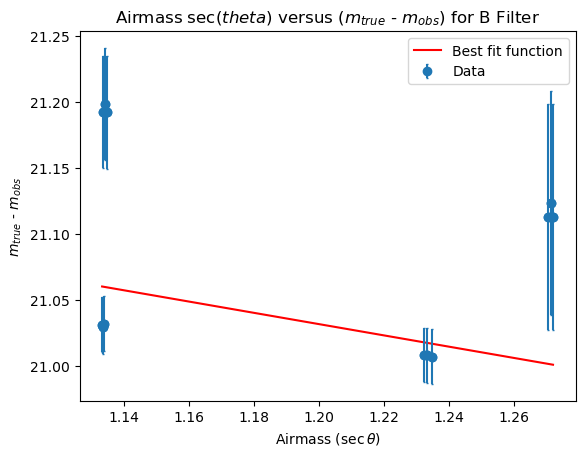

--------------------------------------------------
Filter: B
Extinction Coefficient (k): 0.4267 ± 0.3155
Zero-Point Magnitude (m_0): 21.5434 ± 0.3729
--------------------------------------------------


In [111]:
# plot for B filter

ins_mags_B, ins_mags_err_B, airmasses_B = filter_ins_mag_vs_airmass('B')
mags_B = np.array(stn_mags_B) - np.array(ins_mags_B)

k_B, k_B_err, m_zpt_B, m_zpt_B_err = perform_extinction_correction(mags_B, airmasses_B, ins_mags_err_B, 'B')

#print(ins_mags_B)
#print(ins_mags_err_B)
#print(stn_mags_B)
#print(mags_B)
#print(airmasses_B)


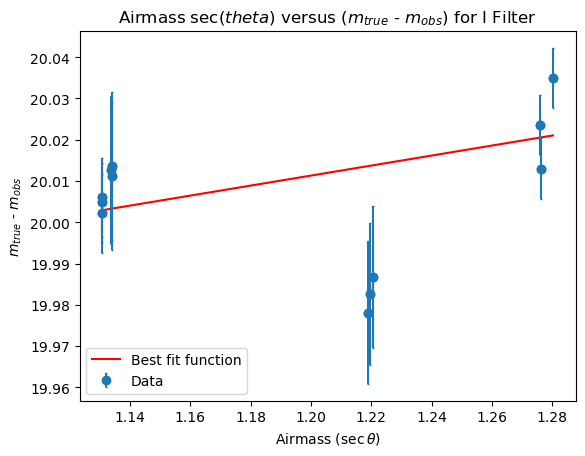

--------------------------------------------------
Filter: I
Extinction Coefficient (k): -0.1212 ± 0.0556
Zero-Point Magnitude (m_0): 19.8659 ± 0.0678
--------------------------------------------------


In [112]:
# plot for I filter
ins_mags_I, ins_mags_err_I, airmasses_I = filter_ins_mag_vs_airmass('I')
mags_I = np.array(stn_mags_I) - np.array(ins_mags_I)

k_I, k_I_err, m_zpt_I, m_zpt_I_err = perform_extinction_correction(mags_I, airmasses_I, ins_mags_err_I, 'I')

[np.float64(1.130866340444971), np.float64(1.130912668908612), np.float64(1.13096190451733), np.float64(1.2025184008197178), np.float64(1.20290803486165), np.float64(1.2053554079703996), np.float64(1.1373367897329634), np.float64(1.1371934432328195), np.float64(1.1370979331791051), np.float64(1.276170963107757), np.float64(1.275577904039261), np.float64(1.2754505990748097)]


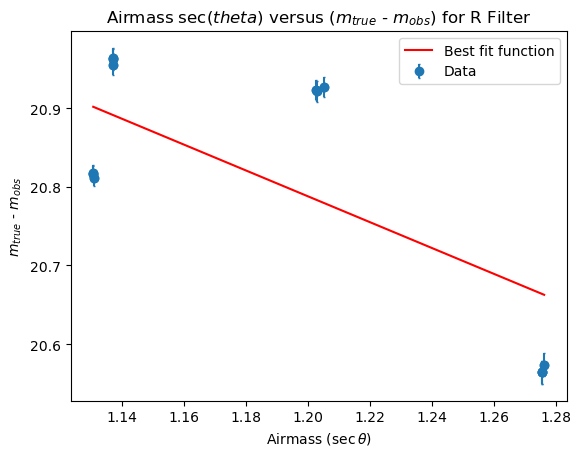

--------------------------------------------------
Filter: R
Extinction Coefficient (k): 1.6455 ± 0.5781
Zero-Point Magnitude (m_0): 22.7626 ± 0.6805
--------------------------------------------------


In [115]:
# plot for R filter
ins_mags_R, ins_mags_err_R, airmasses_R = filter_ins_mag_vs_airmass('R')
mags_R = np.array(stn_mags_R) - np.array(ins_mags_R)
print(airmasses_R)

k_R, k_R_err, m_zpt_R, m_zpt_R_err = perform_extinction_correction(mags_R, airmasses_R, ins_mags_err_R, 'R')

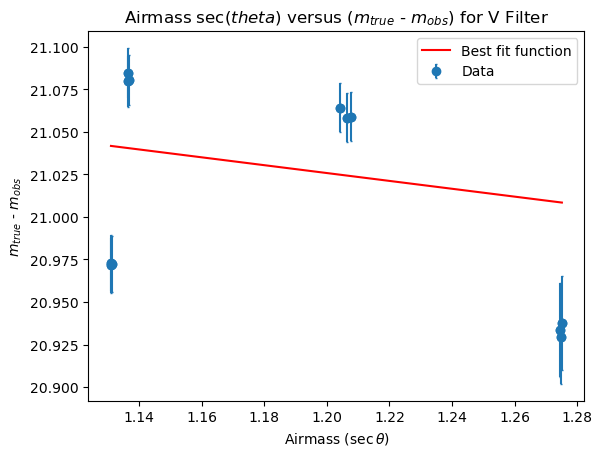

--------------------------------------------------
Filter: V
Extinction Coefficient (k): 0.2312 ± 0.3550
Zero-Point Magnitude (m_0): 21.3032 ± 0.4160
--------------------------------------------------


In [114]:
# plot for V filter
ins_mags_V, ins_mags_err_V, airmasses_V = filter_ins_mag_vs_airmass('V')
mags_V = np.array(stn_mags_V) - np.array(ins_mags_V)

k_V, k_V_err, m_zpt_V, m_zpt_V_err = perform_extinction_correction(mags_V, airmasses_V, ins_mags_err_V, 'V')

In [ ]:
target_ins_mag = []
target_ins_mag_err = []
target_airmass = []

In [126]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter B

ins_mag_target_B, ins_mags_err_target_B, airmasses_target_B = filter_ins_mag_vs_airmass('B')

m_target_B = ins_mag_target_B + (np.ones(len(airmasses_target_B))* k_B * airmasses_target_B) + m_zpt_B
#print(m_target_B)

mean_m_target_B = np.mean(m_target_B)
m_target_B_err = np.std(m_target_B)
print(f"{mean_m_target_B} ± {m_target_B_err}")

13.573528302840344 ± 0.7711797922620133


In [127]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter V

ins_mag_target_V, ins_mags_err_target_V, airmasses_target_V = filter_ins_mag_vs_airmass('V')

m_target_V = ins_mag_target_V + (np.ones(len(airmasses_target_V))* k_V * airmasses_target_V) + m_zpt_V
#print(m_target_V)

mean_m_target_V = np.mean(m_target_V)
m_target_V_err = np.std(m_target_V)
print(f"{mean_m_target_V} ± {m_target_V_err}")

12.05568265242245 ± 0.37024862346332504


In [124]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter R

ins_mag_target_R, ins_mags_err_target_R, airmasses_target_R = filter_ins_mag_vs_airmass('R')

m_target_R = ins_mag_target_R + (np.ones(len(airmasses_target_R))* k_B * airmasses_target_R) + m_zpt_R
#print(m_target_R)

mean_m_target_R = np.mean(m_target_R)
m_target_R_err = np.std(m_target_R)
print(f"{mean_m_target_R} ± {m_target_R_err}")

13.220010819117045 ± 0.2038970151905454


In [125]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter I

ins_mag_target_I, ins_mags_err_target_I, airmasses_target_I = filter_ins_mag_vs_airmass('I')

m_target_I = ins_mag_target_I + (np.ones(len(airmasses_target_I))* k_I * airmasses_target_I) + m_zpt_I
#print(m_target_I)

mean_m_target_I = np.mean(m_target_I)
m_target_I_err = np.std(m_target_I)
print(f"{mean_m_target_I} ± {m_target_I_err}")

9.684334016520213 ± 0.7083057260355144


In [131]:
B_V = mean_m_target_B - mean_m_target_V
print(B_V) # not right :( 

1.517845650417895
